In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis

%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
day_to_analyze = datetime.strptime("2020-10-23", "%Y-%m-%d")
env = "PAPER"

In [3]:
trades = analysis.load_trades(day_to_analyze, env)
algo_runs = analysis.load_runs(day_to_analyze, env)

[93421]2020-10-26 07:25:30.684727:db connection pool initialized


In [4]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
#batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_batch_revenue(x, trades, batch_id)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades, batch_id)
    )

    if len(algo_runs.loc[algo_runs["batch_id"] == batch_id]
        .start_time) > 0:
        batch_time = (
            algo_runs.loc[algo_runs["batch_id"] == batch_id]
            .start_time.min()
            .tz_localize("utc")
            .astimezone(est)
        ) 
    else:
        continue
    
    env = algo_runs[algo_runs["batch_id"] == batch_id].algo_env.tolist()[0]
    print(
        f"[{env}] {batch_id}\n{batch_time}\nTotal revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

[PAPER] 007b299b-ad6e-432c-86fb-cba371506802
2020-10-23 09:30:04.575031-04:00
Total revenues=$-229.64


,symbol,revenues,count
0,BKD,21.24,2
1,CARV,-89.38,4
2,CGA,-21.40,2
3,CHFS,102.51,3
4,CLB,-28.06,2
5,CLF,46.41,2
6,CRS,27.78,2
7,FNKO,30.72,2
8,GEO,-93.44,3
9,HLX,6.93,2


In [5]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

BKD analysis with profit $21.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1831.95,-1831.95,buy,2020-10-23 10:25:28.778673-04:00,3.45,531,3.29%,1.06%,"{'buy': {'avg': 3.3754, 'macd': [0.014305974355742546, 0.01404770462466498, 0.014482989540491431, 0.01625441801254368, 0.019052495385091017], 'vwap': 3.4521, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.014942397416914817, 0.01476345885846485, 0.014707364994870166, 0.015016775598404869, 0.015823919555742097]}, 'sell': None}",4.00,3.28
1,21.24,1853.19,sell,2020-10-23 10:28:31.348536-04:00,3.49,531,4.49%,,"{'buy': None, 'sell': {'avg': 3.3912, 'rsi': [76.3148689373308, 76.3148689373308, 79.36273526462107], 'vwap': 3.4944, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014492753623188354, 'sell_macd': [0.00953639349459623, 0.011342828521332837, 0.013642091808123258, 0.015256555514607584, 0.017064494045444523], 'sell_macd_signal': [0.008774075661879707, 0.009287826233770332, 0.010158679348640917, 0.01117825458183425, 0.012355502474556305]}}",4.00,3.28


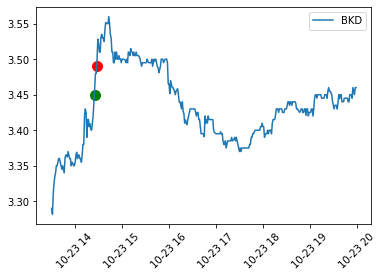

CARV analysis with profit $-89.38


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2151.36,-2151.36,buy,2020-10-23 10:04:28.317494-04:00,7.47,288,4.03%,1.57%,"{'buy': {'avg': 7.2931, 'macd': [0.05932484459239262, 0.057518920009884233, 0.05784169795794902, 0.061822886402069344, 0.06423751681951906], 'vwap': 7.481, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.05991917884506709, 0.05943912707803052, 0.05911964125401422, 0.059660290283625246, 0.06057573559080401]}, 'sell': None}",8.47,7.15
1,8.64,2160.00,sell,2020-10-23 10:15:22.298295-04:00,7.50,288,4.45%,,"{'buy': None, 'sell': {'avg': 7.3634, 'rsi': [71.73478421799577, 59.02326486791852, 59.874079305780235], 'vwap': 7.55, 'reasons': 'bail', 'movement': 0.01070950468540831, 'sell_macd': [0.04899718238348161, 0.052063856441544765, 0.053101993935599445, 0.04854597128245164, 0.0448848371204873], 'sell_macd_signal': [0.04085208430981052, 0.04309443873615737, 0.045095949776045786, 0.045785954077326954, 0.04560573068595902]}}",8.47,7.15
2,-2784.93,-2793.57,buy,2020-10-23 10:46:48.826114-04:00,7.41,377,3.19%,2.93%,"{'buy': {'avg': 7.3911, 'macd': [-0.03550651709836128, -0.03135784818256493, -0.02934555375357828, -0.027434547534245013, -0.0237101461084519], 'vwap': 7.414, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.02855780235005841, -0.029117811516559712, -0.029163359963963426, -0.028817597478019742, -0.027796107204106173]}, 'sell': None}",8.17,7.16
3,-89.38,2695.55,sell,2020-10-23 12:24:14.831709-04:00,7.15,377,-0.43%,,"{'buy': None, 'sell': {'avg': 7.3818, 'rsi': [45.41768440501268, 45.293061172404116, 34.577323855364575], 'vwap': 7.1974, 'reasons': 'stopped', 'movement': -0.033738191632928474, 'sell_macd': [-0.015309895644723959, -0.014058899832212646, -0.013041774525941463, -0.012121394098640437, -0.013662378257903285], 'sell_macd_signal': [-0.014370693488576194, -0.014308334757303484, -0.01405502271103108, -0.013668296988552951, -0.013667113242423017]}}",8.17,7.16


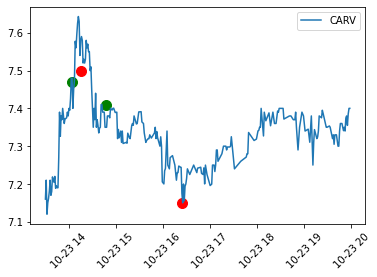

CGA analysis with profit $-21.40


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-721.18,-721.18,buy,2020-10-23 10:03:28.821168-04:00,3.37,214,22.7%,10.79%,"{'buy': {'avg': 3.0429, 'macd': [0.050717953792092985, 0.05044738236632629, 0.054622320624015064, 0.08439331418061968, 0.09917807193373651], 'vwap': 3.3958, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.06647021304946955, 0.0632656469128409, 0.06153698165507573, 0.06610824816018451, 0.07272221291489492]}, 'sell': None}",4.65,2.88
1,-21.40,699.78,sell,2020-10-23 10:03:31.056580-04:00,3.27,214,19.06%,,"{'buy': None, 'sell': {'avg': 3.0471, 'rsi': [68.19831814075272, 82.96782609332524, 80.58510857695545], 'vwap': 3.2973, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.008872403560830872, 'sell_macd': [0.02794136739876807, 0.02778976945248335, 0.030541903917034485, 0.04995211383854148, 0.05805419801324119], 'sell_macd_signal': [0.038607712399705174, 0.03644412381026081, 0.035263679831615546, 0.038201366633000736, 0.042171932909048825]}}",4.65,2.88


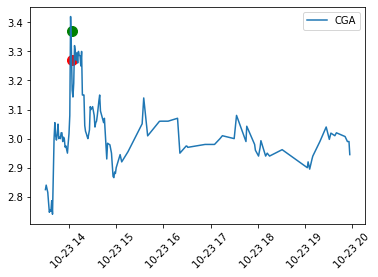

CHFS analysis with profit $102.51


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2733.60,-2733.60,buy,2020-10-23 10:51:45.569536-04:00,6.80,402,3.5%,3.43%,"{'buy': {'avg': 6.7953, 'macd': [-0.01900877421732794, -0.01773676705172811, -0.018133493437065162, -0.014249065466179545, -0.007062700925273724], 'vwap': 6.8099, 'reason': ['MACD crossover', 'MACD histogram reversal'], 'macd_signal': [-0.017695681254375577, -0.017703898413846085, -0.017789817418489902, -0.017081667028027832, -0.015077873807477011]}, 'sell': None}",7.52,6.57
1,-1308.51,1425.09,sell,2020-10-23 11:13:39.154171-04:00,7.09,201,7.91%,,"{'buy': None, 'sell': {'avg': 6.8341, 'rsi': [72.14999742948837, 67.67023107703105, 69.37113097823512], 'vwap': 7.095, 'reasons': 'scale-out', 'movement': 0.04338235294117646, 'sell_macd': [0.0451906698066491, 0.04556178247931708, 0.04889561336088555, 0.049325928160017796, 0.050293369196224624], 'sell_macd_signal': [0.03165997202070517, 0.03444033411242755, 0.03733138996211915, 0.039730297601698876, 0.04184291192060403]}}",7.52,6.57
2,102.51,1411.02,sell,2020-10-23 11:16:56.433335-04:00,7.02,201,6.85%,,"{'buy': None, 'sell': {'avg': 6.8551, 'rsi': [69.37995226827998, 65.94719340080161, 64.23583349741905], 'vwap': 7.0693, 'reasons': 'bail', 'movement': -0.0028208744710859768, 'sell_macd': [0.050469992572848454, 0.05049822467930287, 0.050155311714471296, 0.04819777808324499, 0.04549063787601426], 'sell_macd_signal': [0.04187823659592879, 0.043602234212603605, 0.04491284971297714, 0.04556983538703071, 0.04555399588482742]}}",7.52,6.57


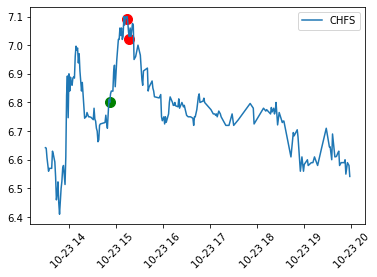

CLB analysis with profit $-28.06


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1901.98,-1901.98,buy,2020-10-23 10:02:02.866365-04:00,15.59,122,2.97%,-0.28%,"{'buy': {'avg': 15.0979, 'macd': [0.09575612847575243, 0.09340681111762095, 0.09209715437130583, 0.09799873778235302, 0.10389885312967095], 'vwap': 15.5916, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.09403087268648846, 0.09390606037271496, 0.09354427917243313, 0.09443517089441711, 0.09632790734146787]}, 'sell': None}",17.92,14.81
1,-28.06,1873.92,sell,2020-10-23 15:45:05.798001-04:00,15.36,122,1.45%,,"{'buy': None, 'sell': {'liquidation': 1}}",17.92,14.81


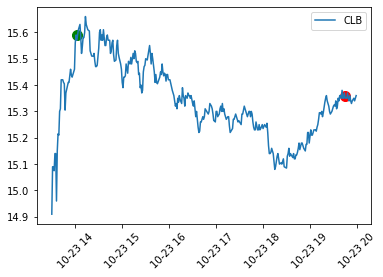

CLF analysis with profit $46.41


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2364.18,-2364.18,buy,2020-10-23 09:52:30.004186-04:00,8.66,273,0.58%,-1.02%,"{'buy': {'avg': 8.5226, 'macd': [0.04403051170489114, 0.043724409834812406, 0.047772627345892715, 0.0519953319218569, 0.056178985570580764], 'vwap': 8.6599, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0527152097210575, 0.05091704974380848, 0.050288165264225325, 0.05062959859575164, 0.051739475990717466]}, 'sell': None}",9.71,8.32
1,46.41,2410.59,sell,2020-10-23 10:22:16.630321-04:00,8.83,273,2.56%,,"{'buy': None, 'sell': {'avg': 8.6151, 'rsi': [64.64629109299355, 67.68884804883419, 67.6888480488342], 'vwap': 8.7897, 'reasons': 'bail', 'movement': 0.020207852193995464, 'sell_macd': [0.024515357531415205, 0.023807728272538853, 0.02372635835299164, 0.02465351999551224, 0.022702561275458777], 'sell_macd_signal': [0.026690703622547378, 0.026114108552545673, 0.025636558512634865, 0.02543995080921034, 0.02489247290246003]}}",9.71,8.32


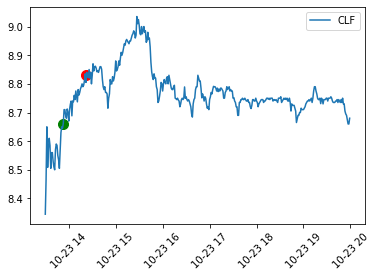

CRS analysis with profit $27.78


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,8676.62,8676.62,sell,2020-10-23 10:18:44.313131-04:00,18.74,463,-0.85%,,"{'buy': None, 'sell': {'avg': 18.8148, 'vwap': 18.75, 'volume': [1224.0, 2464.0, 7512.0, 4854.0, 4318.0], '5-min-close': [19.18, 19.185, 19.04, 18.955, 18.75], 'vwap_series': [18.925536351563373, 18.942355886884496, 18.95772779024354, 18.96049613319556, 18.95549431164277]}}",18.13,18.96
1,27.78,-8648.84,buy,2020-10-23 10:31:57.797125-04:00,18.68,463,-1.16%,,"{'buy': {'reason': 'reversing direction', 'close_5m': [18.955, 18.69, 18.56, 18.6, 18.64]}, 'sell': None}",18.13,18.96


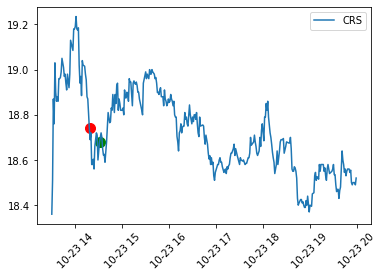

FNKO analysis with profit $30.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3210.24,-3210.24,buy,2020-10-23 10:58:41.488297-04:00,6.27,512,2.45%,1.13%,"{'buy': {'avg': 6.1892, 'macd': [0.011127351737342472, 0.01025852304257846, 0.011056352150183635, 0.01195429401910264, 0.013718159654078299], 'vwap': 6.27, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.012247122285729562, 0.011849402437099341, 0.0116907923797162, 0.011743492707593488, 0.012138426096890451]}, 'sell': None}",6.83,6.08
1,30.72,3240.96,sell,2020-10-23 12:22:56.229382-04:00,6.33,512,3.43%,,"{'buy': None, 'sell': {'avg': 6.2674, 'rsi': [48.79893372398632, 46.31510192477374, 43.656213641469385], 'vwap': 6.33, 'reasons': 'bail', 'movement': 0.009569377990430701, 'sell_macd': [0.007036826054295453, 0.006765747345274242, 0.0053757412428510065, 0.0037552723157308066, 0.001924318965822458], 'sell_macd_signal': [0.002379665716841663, 0.003256882042528179, 0.0036806538825927444, 0.003695577569220357, 0.003341325848540777]}}",6.83,6.08


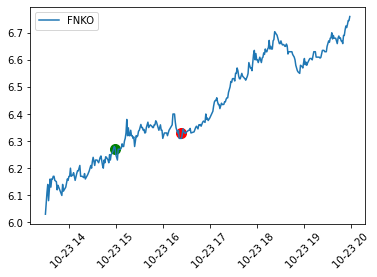

GEO analysis with profit $-93.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-348.17,-348.17,buy,2020-10-23 10:03:14.680012-04:00,9.41,37,1.62%,0.3%,"{'buy': {'avg': 9.2878, 'macd': [0.037977120444741885, 0.040539051848851315, 0.04447744195920578, 0.046170739715647, 0.047617389072224015], 'vwap': 9.417, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.047687221854872515, 0.04625758785366828, 0.04590155867477578, 0.04595539488295002, 0.04628779372080482]}, 'sell': None}",10.39,9.09
1,-2747.72,-2399.55,buy,2020-10-23 10:03:14.852999-04:00,9.41,255,1.62%,0.3%,"{'buy': {'avg': 9.2878, 'macd': [0.037977120444741885, 0.040539051848851315, 0.04447744195920578, 0.046170739715647, 0.047617389072224015], 'vwap': 9.417, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.047687221854872515, 0.04625758785366828, 0.04590155867477578, 0.04595539488295002, 0.04628779372080482]}, 'sell': None}",10.39,9.09
2,-93.44,2654.28,sell,2020-10-23 11:01:17.774836-04:00,9.09,292,-1.84%,,"{'buy': None, 'sell': {'avg': 9.3263, 'rsi': [21.592497790318244, 16.59477962402097, 14.9229977253899], 'vwap': 9.0975, 'reasons': 'stopped', 'movement': -0.034006376195536696, 'sell_macd': [-0.026845024132022388, -0.02714206674459163, -0.027047008173287423, -0.02893336502456556, -0.030676846142126735], 'sell_macd_signal': [-0.02714520400602216, -0.027144576553736054, -0.02712506287764633, -0.027486723307030177, -0.028124747874049488]}}",10.39,9.09


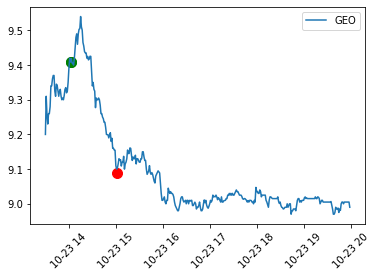

HLX analysis with profit $6.93


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1981.98,-1981.98,buy,2020-10-23 09:55:17.922970-04:00,2.86,693,3.25%,0.22%,"{'buy': {'avg': 2.7762, 'macd': [0.020950764715055747, 0.021167653890487248, 0.02122398980980833, 0.022661586443922577, 0.024957577123710717], 'vwap': 2.8505, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.022032927151900184, 0.021859872499617596, 0.021732695961655744, 0.02191847405810911, 0.022526294671229432]}, 'sell': None}",3.27,2.72
1,6.93,1988.91,sell,2020-10-23 10:10:08.750533-04:00,2.87,693,3.61%,,"{'buy': None, 'sell': {'avg': 2.8111, 'rsi': [56.185956139930894, 56.21321784575998, 57.32835519595222], 'vwap': 2.864, 'reasons': 'bail post whipsawed', 'movement': 0.0013986013986014, 'sell_macd': [0.017252333564097277, 0.015943188974646194, 0.014196541385792294, 0.01265634142842842, 0.01149441494959369], 'sell_macd_signal': [0.016453011916441496, 0.016351047328082437, 0.01592014613962441, 0.01526738519738521, 0.014512791147826906]}}",3.27,2.72


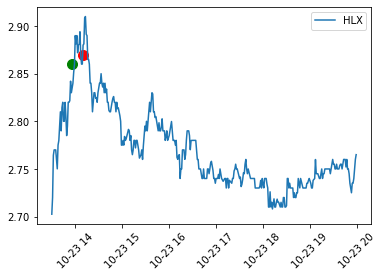

HP analysis with profit $-93.08


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2858.63,-2858.63,buy,2020-10-23 10:31:33.246571-04:00,15.97,179,3.17%,1.32%,"{'buy': {'avg': 15.6838, 'macd': [0.03990548885911949, 0.04165109859102145, 0.044139526744608304, 0.05117018097611137, 0.05609539234294658], 'vwap': 15.9791, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.054066148341270395, 0.051583138391220605, 0.05009441606189814, 0.050309569044740786, 0.05146673370438194]}, 'sell': None}",17.56,15.44
1,-93.08,2765.55,sell,2020-10-23 14:35:48.821484-04:00,15.45,179,-0.19%,,"{'buy': None, 'sell': {'avg': 15.7372, 'rsi': [37.537551627290206, 31.31603935819236, 29.557465398892862], 'vwap': 15.4458, 'reasons': 'stopped', 'movement': -0.033187226048841646, 'sell_macd': [-0.020726323022188353, -0.01911269055078968, -0.017607097838650887, -0.01776368666245709, -0.017873188516558614], 'sell_macd_signal': [-0.02660108921496438, -0.02510340948212944, -0.02360414715343373, -0.0224360550552384, -0.021523481747502442]}}",17.56,15.44


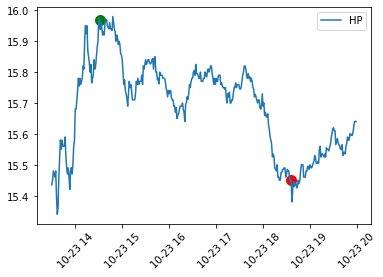

IEA analysis with profit $-1.78


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1536.14,-1536.14,buy,2020-10-23 10:06:24.081204-04:00,8.63,178,4.23%,2.1%,"{'buy': {'avg': 8.454, 'macd': [0.03459622240878879, 0.034342700134867954, 0.03758973880760941, 0.04304779202633746, 0.06119244577860172], 'vwap': 8.5781, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.038894138970953555, 0.037983851203736436, 0.03790502872451103, 0.03893358138487631, 0.043385354263621397]}, 'sell': None}",10.23,8.11
1,-1.78,1534.36,sell,2020-10-23 10:16:08.673444-04:00,8.62,178,4.11%,,"{'buy': None, 'sell': {'avg': 8.525, 'rsi': [64.46245031738032, 53.08564951673448, 54.24931488435032], 'vwap': 8.6373, 'reasons': 'bail', 'movement': 0.0008458864426418277, 'sell_macd': [0.08024678974772925, 0.08742339091935136, 0.08793212701517028, 0.07658916647924663, 0.06817401325022665], 'sell_macd_signal': [0.05760605048760637, 0.06356951857395537, 0.06844204026219836, 0.07007146550560801, 0.06969197505453174]}}",10.23,8.11


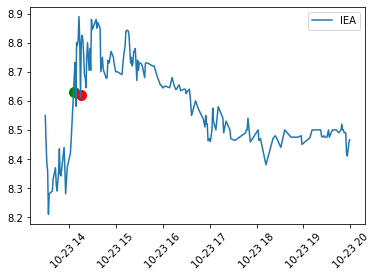

JDST analysis with profit $5.52


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2072.82,-2072.82,buy,2020-10-23 10:46:31.060366-04:00,10.74,193,1.21%,-0.1%,"{'buy': {'avg': 10.6004, 'macd': [0.010462835707507168, 0.011058112027621192, 0.012993919833665046, 0.017553382703543008, 0.022489105661954056], 'vwap': 10.7496, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.014314199270235538, 0.01366298182171267, 0.013529169424103146, 0.014334012079991118, 0.015965030796383707]}, 'sell': None}",11.78,10.41
1,-2964.24,-891.42,buy,2020-10-23 10:46:31.268369-04:00,10.74,83,1.21%,-0.1%,"{'buy': {'avg': 10.6004, 'macd': [0.010462835707507168, 0.011058112027621192, 0.012993919833665046, 0.017553382703543008, 0.022489105661954056], 'vwap': 10.7496, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.014314199270235538, 0.01366298182171267, 0.013529169424103146, 0.014334012079991118, 0.015965030796383707]}, 'sell': None}",11.78,10.41
2,5.52,2969.76,sell,2020-10-23 11:57:02.389988-04:00,10.76,276,1.4%,,"{'buy': None, 'sell': {'avg': 10.6449, 'rsi': [67.87894586560749, 63.522782824399435, 57.90471279377214], 'vwap': 10.7601, 'reasons': 'bail post whipsawed', 'movement': 0.0018621973929236102, 'sell_macd': [0.01967595690763524, 0.019315787338104684, 0.01904402160420915, 0.018044671401119317, 0.016278363822072706], 'sell_macd_signal': [0.015308576311713343, 0.016110018516991613, 0.01669681913443512, 0.01696638958777196, 0.01682878443463211]}}",11.78,10.41


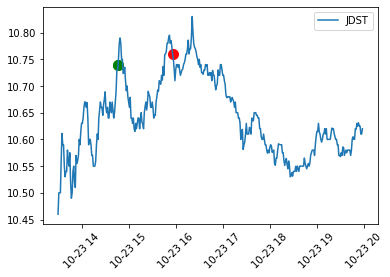

MFA analysis with profit $-7.39


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2172.66,-2172.66,buy,2020-10-23 10:02:36.542493-04:00,2.94,739,2.26%,0.5%,"{'buy': {'avg': 2.8895, 'macd': [0.008516336223407084, 0.008184247669069222, 0.008229656947932096, 0.01034124932370295, 0.013297724839492542], 'vwap': 2.9303, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01028936697979842, 0.00986834311765258, 0.009540605883708484, 0.009700734571707377, 0.01042013262526441]}, 'sell': None}",3.33,2.81
1,-7.39,2165.27,sell,2020-10-23 15:46:36.184135-04:00,2.93,739,1.91%,,"{'buy': None, 'sell': {'liquidation': 1}}",3.33,2.81


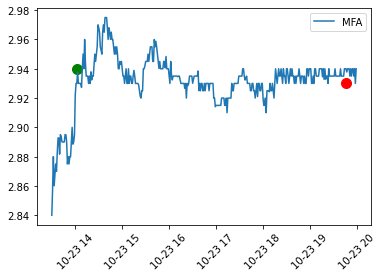

MRIN analysis with profit $95.90


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-993.75,-993.75,buy,2020-10-23 10:06:16.520902-04:00,2.65,375,5.58%,0.6%,"{'buy': {'avg': 2.525, 'macd': [0.015258696966779173, 0.015867013753433135, 0.019967922760031342, 0.027915154343434168, 0.03462121721540612], 'vwap': 2.6473, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.022057020892616314, 0.020819019464779678, 0.02064880012383001, 0.022102070967750843, 0.024605900217281897]}, 'sell': None}",3.41,2.40
1,-473.89,519.86,sell,2020-10-23 10:10:43.609472-04:00,2.78,187,10.76%,,"{'buy': None, 'sell': {'avg': 2.5635, 'rsi': [65.81190796999444, 66.98857389563516, 68.72725623074126], 'vwap': 2.7551, 'reasons': 'scale-out', 'movement': 0.04905660377358487, 'sell_macd': [0.024822545651064676, 0.029493650330943755, 0.03430887929797999, 0.038654396943748726, 0.04180344449962403], 'sell_macd_signal': [0.014341448187757498, 0.01737188861639475, 0.020759286752711797, 0.024338308790919184, 0.027831335932660153]}}",3.41,2.40
2,-192.83,281.06,sell,2020-10-23 10:11:50.862762-04:00,2.99,94,19.12%,,"{'buy': None, 'sell': {'avg': 2.6046, 'rsi': [66.98857389563516, 69.78807948124293, 77.86879184358932], 'vwap': 2.9893, 'reasons': 'scale-out', 'movement': 0.07910071942446043, 'sell_macd': [0.029493650330943755, 0.03430887929797999, 0.038654396943748726, 0.04413591203209144, 0.05766779506155206], 'sell_macd_signal': [0.01737188861639475, 0.020759286752711797, 0.024338308790919184, 0.028297829439153634, 0.03417182256363332]}}",3.41,2.40
3,70.37,263.20,sell,2020-10-23 10:17:11.224136-04:00,2.80,94,11.55%,,"{'buy': None, 'sell': {'avg': 2.766, 'rsi': [54.818162805890225, 57.691076452881376, 58.26155835777873], 'vwap': 2.8094, 'reasons': 'bail', 'movement': -0.06020066889632112, 'sell_macd': [0.07374866115067658, 0.06871638074159447, 0.060941663789821465, 0.056694590011948875, 0.053137200184879774], 'sell_macd_signal': [0.047056621896937476, 0.051388573665868874, 0.053299191690659393, 0.05397827135491729, 0.05381005712090979]}}",3.41,2.40
4,-378.07,-448.44,buy,2020-10-23 10:23:12.196288-04:00,3.03,148,20.72%,11.21%,"{'buy': {'avg': 2.7913, 'macd': [0.08446776589088723, 0.08151362263664508, 0.085449679943018, 0.09552893076774849, 0.10155536453905878], 'vwap': 3.0374, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.08873609557233071, 0.08729160098519359, 0.08692321677675847, 0.08864435957495648, 0.09122656056777693]}, 'sell': None}",4.95,2.39
5,-142.75,235.32,sell,2020-10-23 10:25:14.455737-04:00,3.18,74,26.69%,,"{'buy': None, 'sell': {'avg': 2.8329, 'rsi': [68.74673101206862, 68.95530903799346, 73.19383757852131], 'vwap': 3.1605, 'reasons': 'scale-out', 'movement': 0.049504950495049625, 'sell_macd': [0.05040543804802411, 0.05683491051495482, 0.06241066944353779, 0.06620462874576427, 0.07300245899755442], 'sell_macd_signal': [0.052116020982046984, 0.05305979888862855, 0.0549299729996104, 0.05718490414884118, 0.060348415118583826]}}",4.95,2.39
6,-19.54,123.21,sell,2020-10-23 10:26:25.149712-04:00,3.33,37,32.67%,,"{'buy': None, 'sell': {'avg': 2.8806, 'rsi': [68.95530903799346, 75.61512124967231, 77.0126617897484], 'vwap': 3.3003, 'reasons': 'scale-out', 'movement': 0.04088050314465405, 'sell_macd': [0.05683491051495482, 0.06241066944353779, 0.06620462874576427, 0.07817129016638535, 0.08857425633613714], 'sell_macd_signal': [0.05305979888862855, 0.0549299729996104, 0.05718490414884118, 0.06138218135235001, 0.06682059634910743]}}",4.95,2.39
7,95.90,115.44,sell,2020-10-23 10:32:12.275523-04:00,3.12,37,24.3%,,"{'buy': None, 'sell': {'avg': 2.9642, 'rsi': [68.38596374915397, 59.2651921060965, 58.56364280857777], 'vwap': 3.1202, 'reasons': 'bail', 'movement': -0.06306306306306306, 'sell_macd': [0.0887605791772228, 0.09337373935526871, 0.09315316625562575, 0.08554293830453252, 0.07799285239063458], 'sell_macd_signal': [0.0745464259666304, 0.07831188864435806, 0.0812801441666116, 0.08213270299419578, 0.08130473287348354]}}",4.95,2.39


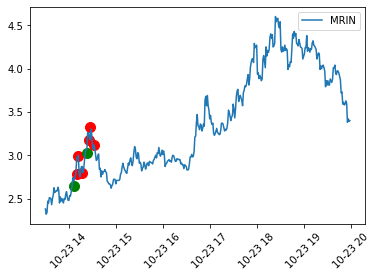

NBEV analysis with profit $4.84


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-755.04,-755.04,buy,2020-10-23 10:35:13.060467-04:00,3.12,242,12.64%,6.4%,"{'buy': {'avg': 2.9472, 'macd': [0.046364307473354405, 0.04395045553496013, 0.04474928429507896, 0.049252648317450465, 0.05142989764190187], 'vwap': 3.1281, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.04648439477144362, 0.04597760692414692, 0.04573194239833333, 0.046436083582156756, 0.04743484639410578]}, 'sell': None}",4.30,2.73
1,4.84,759.88,sell,2020-10-23 10:43:25.969056-04:00,3.14,242,13.36%,,"{'buy': None, 'sell': {'avg': 2.9672, 'rsi': [71.34140568023007, 62.206003407525635, 64.65572040668158], 'vwap': 3.1295, 'reasons': 'bail post whipsawed', 'movement': 0.0031730769230769295, 'sell_macd': [0.02481282365414339, 0.024793525459290144, 0.026539610950842896, 0.025560721581262325, 0.025447811402611986], 'sell_macd_signal': [0.026532205586825345, 0.026184469561318306, 0.026255497839223225, 0.026116542587631044, 0.02598279635062723]}}",4.30,2.73


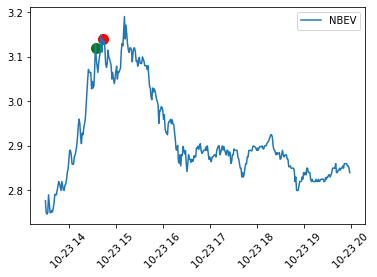

NEX analysis with profit $-98.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1618.80,-1618.80,buy,2020-10-23 10:02:11.092659-04:00,2.13,760,3.34%,0.54%,"{'buy': {'avg': 2.0723, 'macd': [0.009993484484410509, 0.010057816676958709, 0.011589041993890437, 0.013853232290701456, 0.01586815936323749], 'vwap': 2.1289, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.013128051978940115, 0.012514004918543833, 0.012329012333613155, 0.012633856325030815, 0.01328071693267215]}, 'sell': None}",2.50,2.01
1,-98.80,1520.00,sell,2020-10-23 14:13:43.674188-04:00,2.00,760,-2.96%,,"{'buy': None, 'sell': {'avg': 2.0854, 'rsi': [47.648416026479765, 41.2013924290582, 38.08382381725109], 'vwap': 2.0098, 'reasons': 'stopped', 'movement': -0.05868544600938967, 'sell_macd': [-0.0027164243740944727, -0.002326134718149575, -0.002048946223671244, -0.002268683160133733, -0.002420832939713513], 'sell_macd_signal': [-0.0026340187822878653, -0.0025724419694602074, -0.0024677428203024147, -0.0024279308882686782, -0.0024265112985576453]}}",2.50,2.01


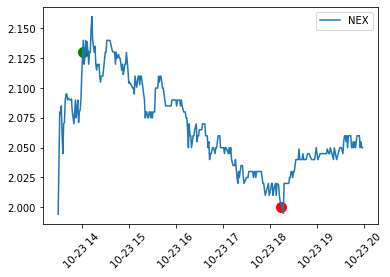

PBF analysis with profit $-100.05


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1987.20,-1987.20,buy,2020-10-23 10:04:13.449594-04:00,5.76,345,3.5%,1.24%,"{'buy': {'avg': 5.6339, 'macd': [0.03461435930820134, 0.035035611461621485, 0.036561827690522186, 0.04053180533207712, 0.04318028575971056], 'vwap': 5.7605, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.03983902720283029, 0.03887834405458853, 0.03841504078177526, 0.03883839369183563, 0.03970677210541061]}, 'sell': None}",6.59,5.48
1,-100.05,1887.15,sell,2020-10-23 12:12:54.315703-04:00,5.47,345,-1.71%,,"{'buy': None, 'sell': {'avg': 5.6216, 'rsi': [32.86143744181697, 31.425642959462134, 28.722650033543847], 'vwap': 5.48, 'reasons': 'stopped', 'movement': -0.048611111111111, 'sell_macd': [-0.010757651026191972, -0.010884561988468988, -0.011101835959224537, -0.01138670092397831, -0.011980274910488475], 'sell_macd_signal': [-0.009840993994018828, -0.01004970759290886, -0.010260133266171995, -0.010485446797733259, -0.010784412420284302]}}",6.59,5.48


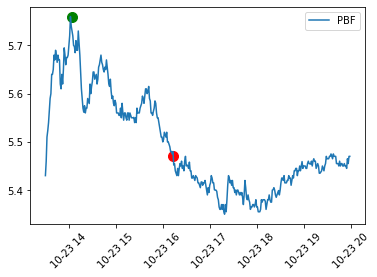

SXC analysis with profit $31.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2531.28,-2531.28,buy,2020-10-23 10:35:52.446818-04:00,3.98,636,3.51%,1.12%,"{'buy': {'avg': 3.8882, 'macd': [0.010657903114005496, 0.010852831551071418, 0.010881874268988234, 0.011977199768564706, 0.013895449664032444], 'vwap': 3.98, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01163100184210723, 0.011475367783900067, 0.0113566690809177, 0.011480775218447101, 0.01196371010756417]}, 'sell': None}",4.43,3.83
1,31.80,2563.08,sell,2020-10-23 10:46:57.253567-04:00,4.03,636,4.81%,,"{'buy': None, 'sell': {'avg': 3.9291, 'rsi': [69.60924284280097, 72.37807513549909, 80.23361766401422], 'vwap': 4.0369, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.015075376884422124, 'sell_macd': [0.009143139237266507, 0.00927100267123837, 0.009769714403278229, 0.010545727254176018, 0.012935533017808254], 'sell_macd_signal': [0.007987371726257565, 0.008244097915253726, 0.008549221212858626, 0.008948522421122105, 0.009745924540459335]}}",4.43,3.83


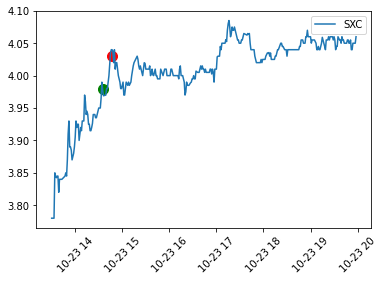

UE analysis with profit $-22.82


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3455.60,-3455.60,buy,2020-10-23 10:32:06.140155-04:00,10.60,326,1.15%,0.53%,"{'buy': {'avg': 10.5356, 'macd': [0.0025903560795956793, 0.003010705816215875, 0.0041034504153767415, 0.004912826378648205, 0.007086407815641849], 'vwap': 10.6, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.004968628133272307, 0.004577043669861021, 0.004482325018964165, 0.004568425290900973, 0.005072021795849148]}, 'sell': None}",11.48,10.31
1,-22.82,3432.78,sell,2020-10-23 15:46:51.156347-04:00,10.53,326,0.48%,,"{'buy': None, 'sell': {'liquidation': 1}}",11.48,10.31


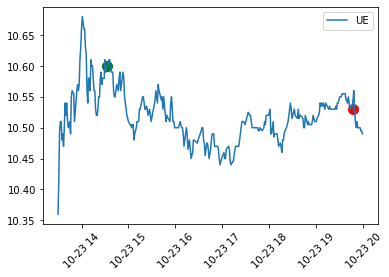

XHR analysis with profit $-47.09


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2675.82,-2675.82,buy,2020-10-23 10:18:14.316838-04:00,9.66,277,2.55%,0.67%,"{'buy': {'avg': 9.4828, 'macd': [0.04225280684794619, 0.04773551269089005, 0.04989164390469725, 0.052607796349649405, 0.05413631696777976], 'vwap': 9.66, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.051294739697981984, 0.050582894296563596, 0.050444644218190324, 0.05087727464448214, 0.051529083109141664]}, 'sell': None}",10.69,9.32
1,-47.09,2628.73,sell,2020-10-23 15:09:11.248548-04:00,9.49,277,0.74%,,"{'buy': None, 'sell': {'avg': 9.5158, 'rsi': [57.00238896124987, 75.85134998131636, 79.55900316458285], 'vwap': 9.5094, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.017060041407867453, 'sell_macd': [-0.007117713632483813, -0.006106716839401116, -0.004200658080643294, 0.001287188459695443, 0.007801261238403967], 'sell_macd_signal': [-0.0086459714927033, -0.008138120562042864, -0.00735062806576295, -0.005623064760671271, -0.0029381995608562233]}}",10.69,9.32


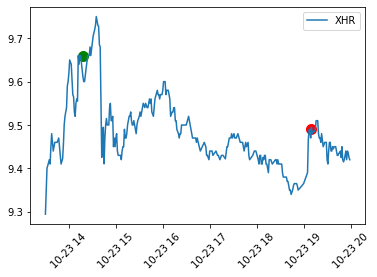

In [6]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(
        hour=9, minute=30, second=0, microsecond=0, tzinfo=None
    )
    end_date = start_date.replace(hour=16, minute=0, tzinfo=None)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        start_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
        end_index = minute_history[symbol]["close"].index.get_loc(
            end_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = float(minute_history[symbol]["close"][cool_minute_history_index])
    plt.plot(
        minute_history[symbol]["close"][start_index:end_index],
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()